# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
! pip install lightgbm

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.dummy import DummyRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, make_scorer

In [3]:
data = pd.read_csv('/autos.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [ ]:
data.head()

In [5]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


DataFrame содержит 354369 обекта и 15 признаков, как с типом object и int, в ряде признаков с типом object имеются пропуски.

In [7]:
data.DateCrawled = pd.to_datetime(data['DateCrawled'], format='%Y-%m-%d %H:%M:%S')
data.LastSeen = pd.to_datetime(data['LastSeen'], format='%Y-%m-%d %H:%M:%S')
data.DateCreated = pd.to_datetime(data['DateCreated'], format='%Y-%m-%d')

In [ ]:
for c in [column for column in list(data.columns) if data[column].dtype == object]:
    print(c, ':', data[c].unique())
    print()

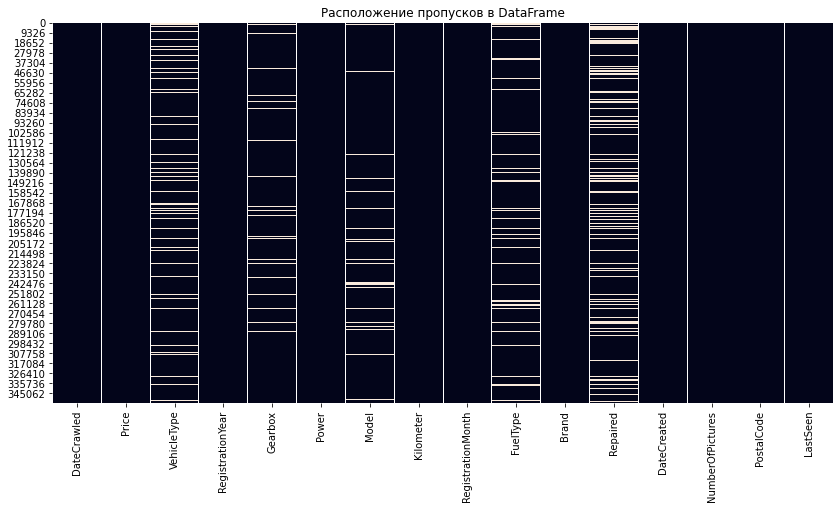

In [9]:
plt.subplots(figsize=(14, 7))
sns.heatmap(data.isnull(), cbar = False)
plt.title('Расположение пропусков в DataFrame')
plt.show()

Часть пропусков колонок 'VehicleType', 'Gearbox' можно востановить из признака Model, однако число востановленных таким способом объектов незначительно (не более 15), пропуски в 'Model', 'FuelType' востановить не удастся, поэтому удалим объекты с пропусками в этих колонках. Пропуски в признаке Repaired можно заменить на значение 'no_info' так как такая информация может отсутствовать (либо удалить весь признак).

In [11]:
data = data.dropna(subset=['Model', 'VehicleType', 'Gearbox', 'FuelType'])
data.Repaired = data['Repaired'].fillna('no_info')

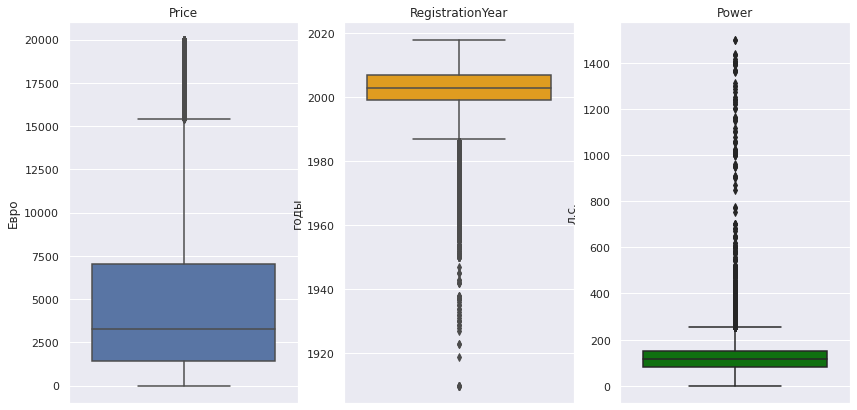

In [12]:
sns.set(rc={'figure.figsize':(14,7)})

plt.subplot(1, 3, 1)
sns.boxplot(data=data.query('Price != 0'), y='Price')
plt.ylabel('Евро')
plt.title("Price")

plt.subplot(1, 3, 2)
sns.boxplot(data=data.query('RegistrationYear != 0 and RegistrationYear < 2023'), y='RegistrationYear', color='orange')
plt.ylabel('годы')
plt.title("RegistrationYear")

plt.subplot(1, 3, 3)
sns.boxplot(data = data.query('Power != 0 and Power <= 1500'), y='Power', color='green')
plt.ylabel('л.с.')
plt.title("Power")

plt.show()

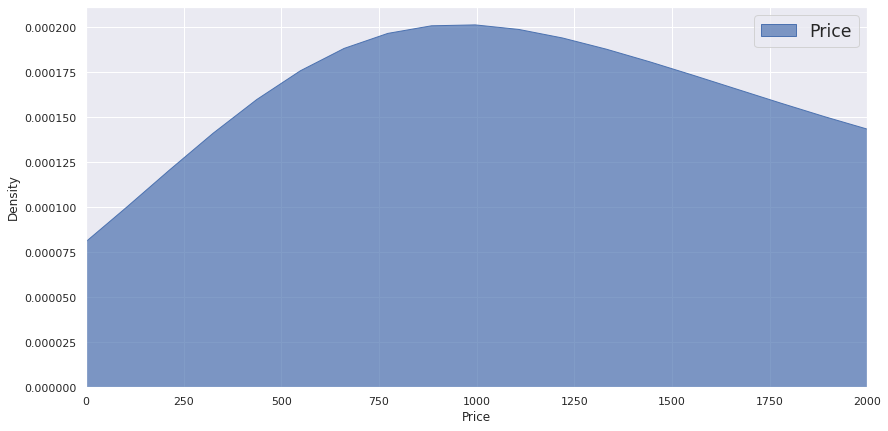

In [13]:
sns.kdeplot(data['Price'], label = 'Price', alpha = .7, shade = True)
#sns.kdeplot(data['Power'], label = 'Power', alpha = .3, shade = True)
plt.xlim([0,2000])

plt.legend(loc = 'upper right', fontsize = 'x-large')

plt.show()

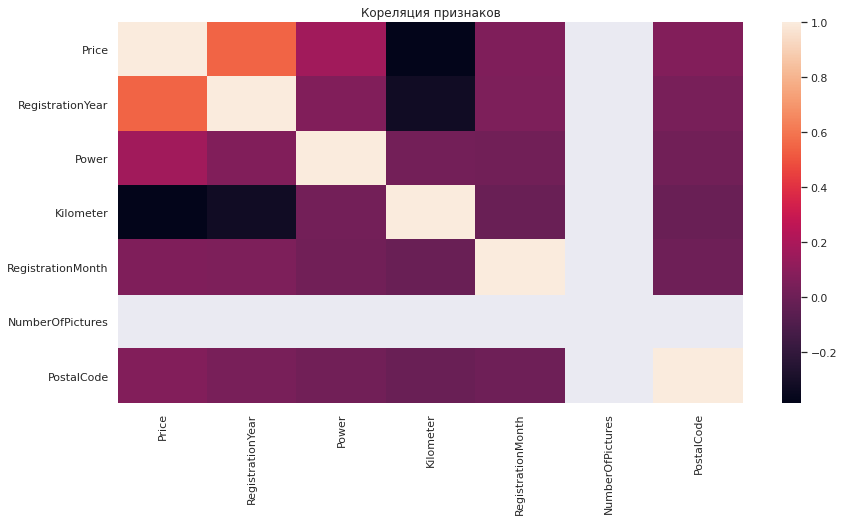

In [14]:
plt.subplots(figsize=(14, 7))
sns.heatmap(data.corr())
plt.title('Кореляция признаков')
plt.show()

Удалим признаки не влияющие на цену, а так же отсечем нехарактерные значения оставшихся признаков.

In [15]:
data = data.query(
   'Price > 100 and 2016 > RegistrationYear >= 1980 and 600 >= Power >= 10').drop(
    ['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis = 1)

In [16]:
data.duplicated().sum()

37529

In [17]:
data = data.drop_duplicates()

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 223225 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             223225 non-null  int64 
 1   VehicleType       223225 non-null  object
 2   RegistrationYear  223225 non-null  int64 
 3   Gearbox           223225 non-null  object
 4   Power             223225 non-null  int64 
 5   Model             223225 non-null  object
 6   Kilometer         223225 non-null  int64 
 7   FuelType          223225 non-null  object
 8   Brand             223225 non-null  object
 9   Repaired          223225 non-null  object
dtypes: int64(4), object(6)
memory usage: 18.7+ MB


In [19]:
data.describe()

,Price,RegistrationYear,Power,Kilometer
count,223225.000000,223225.000000,223225.000000,223225.000000
mean,5193.744899,2003.096002,123.356277,126939.590100
std,4707.644782,5.680268,53.675581,37157.131155
min,101.000000,1980.000000,10.000000,5000.000000
25%,1500.000000,1999.000000,83.000000,125000.000000
50%,3500.000000,2003.000000,116.000000,150000.000000
75%,7500.000000,2007.000000,150.000000,150000.000000
max,20000.000000,2015.000000,600.000000,150000.000000


## Обучение моделей

Разобьем выборку на target и features, целевой признак - 'Price'.

In [20]:
target = data['Price']
features = data.drop(['Price'], axis = 1)

Разделим выборку на тестовую и тренировочную, валидационную получим крос валидацией

In [28]:
features_train, features_test, target_train, target_test = train_test_split(
   features, target, test_size=.2, random_state=12345)

Оценку будем производить метрикой RMSE.

In [29]:
def RMSE(target, predicted):
    return mean_squared_error(target, predicted) ** .5
scorer = make_scorer(RMSE, greater_is_better = False)

In [30]:
numeric = ['RegistrationYear', 'Power', 'Kilometer']
scaler = StandardScaler()
scaler.fit(features_train[numeric]) 
features_train[numeric] = scaler.transform(features_train[numeric]) 
features_test[numeric] = scaler.transform(features_test[numeric])

/tmp/ipykernel_31/610732730.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[numeric] = scaler.transform(features_train[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_31/610732730.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

Найдем лучшую модель.

In [25]:
parametrs = {'n_estimators': range(10, 51, 10),
            'max_depth': range(1,11,1)}

In [26]:
%%time

clf = LGBMRegressor()
grid = GridSearchCV(clf, parametrs, scoring=scorer, n_jobs=-1,cv =5, verbose = 2)
grid.fit(features_train, target_train)
print(grid.best_score_)
grid.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END .......................max_depth=1, n_estimators=10; total time=   6.0s
[CV] END .......................max_depth=1, n_estimators=10; total time=   6.1s
[CV] END .......................max_depth=1, n_estimators=10; total time=   6.1s
[CV] END .......................max_depth=1, n_estimators=10; total time=   6.2s
[CV] END .......................max_depth=1, n_estimators=10; total time=   6.3s
[CV] END .......................max_depth=1, n_estimators=20; total time=   8.8s
[CV] END .......................max_depth=1, n_estimators=20; total time=   8.8s
[CV] END .......................max_depth=1, n_estimators=20; total time=   8.8s
[CV] END .......................max_depth=1, n_estimators=20; total time=   8.5s
[CV] END .......................max_depth=1, n_estimators=20; total time=   8.7s
[CV] END .......................max_depth=1, n_estimators=30; total time=  11.1s
[CV] END .......................max_depth=1, n_

{'max_depth': 10, 'n_estimators': 50}

In [27]:
%%time

clf = GradientBoostingRegressor()
grid = GridSearchCV(clf, parametrs, scoring=scorer, n_jobs=-1,cv =5, verbose = 2)
grid.fit(features_train, target_train)
print(grid.best_score_)
grid.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END .......................max_depth=1, n_estimators=10; total time=   2.8s
[CV] END .......................max_depth=1, n_estimators=10; total time=   2.7s
[CV] END .......................max_depth=1, n_estimators=10; total time=   2.8s
[CV] END .......................max_depth=1, n_estimators=10; total time=   2.9s
[CV] END .......................max_depth=1, n_estimators=10; total time=   2.8s
[CV] END .......................max_depth=1, n_estimators=20; total time=   5.1s
[CV] END .......................max_depth=1, n_estimators=20; total time=   5.0s
[CV] END .......................max_depth=1, n_estimators=20; total time=   5.0s
[CV] END .......................max_depth=1, n_estimators=20; total time=   5.0s
[CV] END .......................max_depth=1, n_estimators=20; total time=   5.1s
[CV] END .......................max_depth=1, n_estimators=30; total time=   7.4s
[CV] END .......................max_depth=1, n_

{'max_depth': 10, 'n_estimators': 50}

In [28]:
%%time

clf = RandomForestRegressor()
grid = GridSearchCV(clf, parametrs, scoring=scorer, n_jobs=-1,cv =5, verbose = 2)
grid.fit(features_train, target_train)
print(grid.best_score_)
grid.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END .......................max_depth=1, n_estimators=10; total time=   2.4s
[CV] END .......................max_depth=1, n_estimators=10; total time=   2.3s
[CV] END .......................max_depth=1, n_estimators=10; total time=   2.3s
[CV] END .......................max_depth=1, n_estimators=10; total time=   2.3s
[CV] END .......................max_depth=1, n_estimators=10; total time=   2.3s
[CV] END .......................max_depth=1, n_estimators=20; total time=   4.0s
[CV] END .......................max_depth=1, n_estimators=20; total time=   4.1s
[CV] END .......................max_depth=1, n_estimators=20; total time=   4.0s
[CV] END .......................max_depth=1, n_estimators=20; total time=   4.0s
[CV] END .......................max_depth=1, n_estimators=20; total time=   4.1s
[CV] END .......................max_depth=1, n_estimators=30; total time=   5.8s
[CV] END .......................max_depth=1, n_

{'max_depth': 10, 'n_estimators': 50}

In [29]:
model = LinearRegression()

scores = cross_val_score(model, features_train, target_train, scoring = scorer, cv=5)

print('Средняя оценка RMSE:', sum(scores)/len(scores))

Средняя оценка RMSE: -2329.75855085817


## Анализ моделей

In [30]:
%%time
model = LGBMRegressor(max_depth = 10, n_estimators = 50)
model.fit(features_train, target_train)

CPU times: user 2min 37s, sys: 3.49 s, total: 2min 40s
Wall time: 2min 41s


LGBMRegressor(max_depth=10, n_estimators=50)

In [31]:
%%time
predicted = model.predict(features_train)
print('оценка RMSE:', RMSE(target_train, predicted))

оценка RMSE: 1683.6153875453074
CPU times: user 1.24 s, sys: 257 ms, total: 1.49 s
Wall time: 1.51 s


In [32]:
%%time
model = GradientBoostingRegressor(max_depth = 10, n_estimators = 50)
model.fit(features_train, target_train)

CPU times: user 2min 48s, sys: 307 ms, total: 2min 48s
Wall time: 2min 49s


GradientBoostingRegressor(max_depth=10, n_estimators=50)

In [33]:
%%time
predicted = model.predict(features_train)
print('оценка RMSE:', RMSE(target_train, predicted))

оценка RMSE: 1384.8711506720215
CPU times: user 1.31 s, sys: 226 ms, total: 1.54 s
Wall time: 1.54 s


In [34]:
%%time
model = RandomForestRegressor(max_depth = 10, n_estimators = 50)
model.fit(features_train, target_train)

CPU times: user 1min 55s, sys: 399 ms, total: 1min 55s
Wall time: 1min 56s


RandomForestRegressor(max_depth=10, n_estimators=50)

In [35]:
%%time
predicted = model.predict(features_train)
print('оценка RMSE:', RMSE(target_train, predicted))

оценка RMSE: 1768.870950849881
CPU times: user 1.17 s, sys: 142 ms, total: 1.31 s
Wall time: 1.32 s


In [31]:
model = LGBMRegressor(max_depth = 10, n_estimators = 50)
model.fit(features_train, target_train)

predicted = model.predict(features_test)
print('оценка RMSE:', RMSE(target_test, predicted))

оценка RMSE: 1698.48211506619


Показатели RMSE лучше у GradientBoostingRegressor выше, однако модель обучается дольше остальных, также дольше делаются предсказания, но на мой взгляд должна быть выбрана эта модель

In [ ]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train, target_train)
dummy =dummy_regr.predict(features_test)
print('оценка RMSE:', RMSE(target_test, dummy))

# Вывод: 
Мы построили модель с минимальным значением RMSE, для этого избавились от пустых значений в исходных данных, удалили неинформативные признаки, перевели категориальные признаки в численные, стандартизировали численые признаки и избавились от дисбаланса. Модель проверена на тестовой выборке.